In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from EmotionDetector import EmotionDetector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import networkx as nx
from collections import Counter
from pyvis.network import Network

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
simpsons_df = pd.read_excel('simpson_lines_wref.xlsx')

In [5]:
simpsons_df.head()

,episode_id,number,location_id,raw_character_text,spoken_words,scene_number,refers
0,128,1,3,Seymour Skinner,"Ah, is there nothing so intoxicating as the sc...",1,NaN
1,128,2,3,Seymour Skinner,Hmm. School normally doesn't smell so... rank.,1,NaN
2,128,3,3,Seymour Skinner,Ahh. Washbasin fresh. That funk must be coming...,1,NaN
3,128,5,3,Seymour Skinner,Poor fellow. Crushed by his own water bottle...,1,NaN
4,128,6,3,Seymour Skinner,"Willie, sometime over the holiday weekend, the...",1,Willie


In [44]:
classifier = EmotionDetector("j-hartmann/emotion-english-roberta-large",0.15)

In [47]:
simpsons_df["emotions"] = simpsons_df['spoken_words'].apply(lambda x: classifier.predict_label(x))

In [51]:
def radar_plot(labels, values, title):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='yellow', linewidth=2, label="")
    ax.fill(angles, values, color='yellow', alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 0.6)
    ax.set_title(title, size=20, color='blue', y=1.1)
    plt.show()

[0.         0.37037037 0.14814815 0.         0.37037037 0.
 0.11111111]


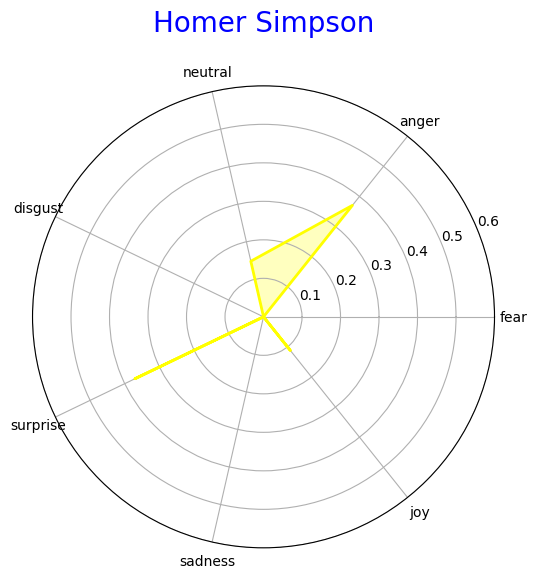

[0.02631579 0.26315789 0.23684211 0.15789474 0.13157895 0.13157895
 0.05263158]


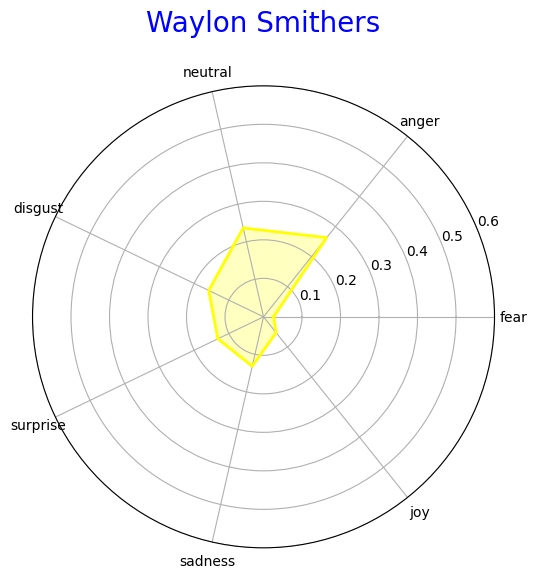

[0.07352941 0.27941176 0.30882353 0.04411765 0.14705882 0.02941176
 0.11764706]


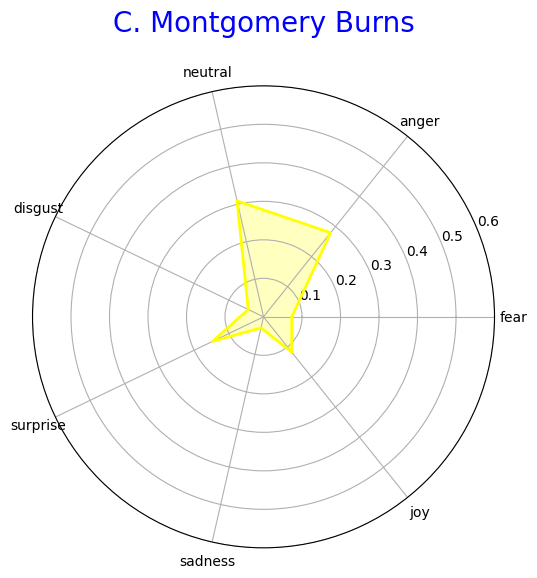

[0.09375 0.09375 0.40625 0.15625 0.03125 0.125   0.09375]


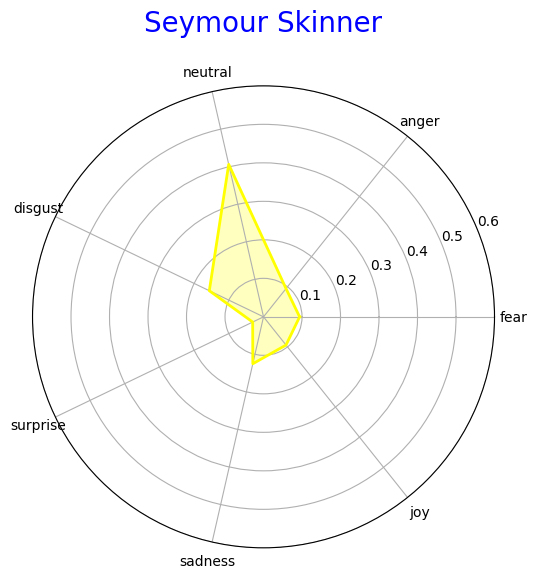

[0.07142857 0.16666667 0.28571429 0.0952381  0.19047619 0.11904762
 0.07142857]


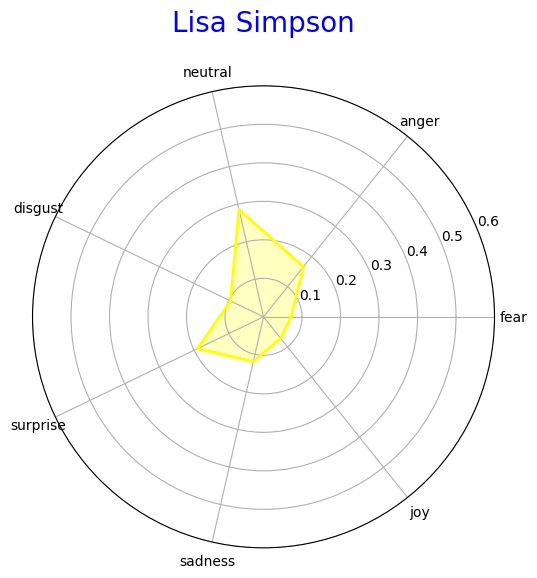

[0.02564103 0.05128205 0.53846154 0.05128205 0.23076923 0.05128205
 0.05128205]


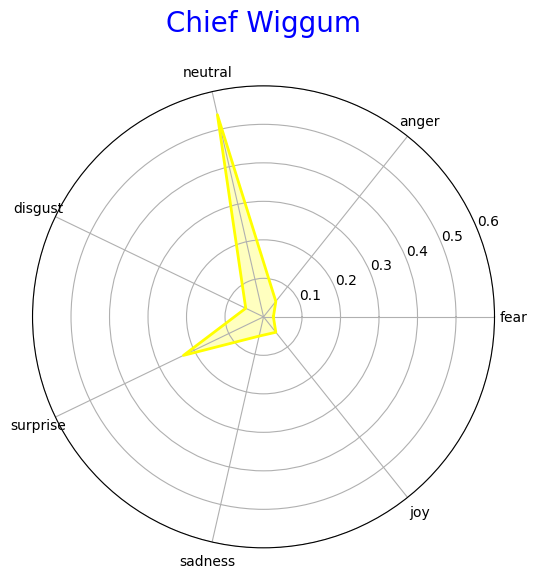

In [124]:
labels = classifier.get_all_labels()
focus_players = ["Homer Simpson", "Waylon Smithers", "C. Montgomery Burns", "Seymour Skinner", "Lisa Simpson", "Chief Wiggum"]
emotions_per_player = simpsons_df.groupby('raw_character_text')['emotions'].value_counts(normalize=True)
for player in focus_players:
    emotions = emotions_per_player.loc[player].reindex(labels).fillna(0).values
    print(emotions)
    radar_plot(labels, emotions, player)

In [54]:
#simpsons_df.groupby(['raw_character_text', "scene_number"])['count'].sum()
df_norm = simpsons_df.groupby(by=["raw_character_text", "scene_number"])["emotions"].value_counts(normalize=True).rename("normalized_counts")
df_abs = simpsons_df.groupby(by=["raw_character_text", "scene_number"])["emotions"].value_counts().rename("absolute_counts")
df_scenes = pd.concat([df_abs, df_norm], axis=1).reset_index()

In [55]:
df_scenes

,raw_character_text,scene_number,emotions,absolute_counts,normalized_counts
0,Bart Simpson,1,disgust,1,1.0
1,Bart Simpson,6,neutral,1,0.5
2,Bart Simpson,6,anger,1,0.5
3,Bart Simpson,9,surprise,1,1.0
4,Bart Simpson,11,anger,1,1.0
...,...,...,...,...,...
230,Waylon Smithers,36,neutral,1,0.2
231,Waylon Smithers,36,sadness,1,0.2
232,Waylon Smithers,36,surprise,1,0.2
233,Waylon Smithers,37,joy,1,1.0


In [56]:
color_palette = {'sadness': '#3457D5', 'joy': '#177245', 'disgust': '#8A2BE2',
                    'anger': '#960018', 'fear': '#FF4F00', 'surprise': '#FFBF00', 'neutral': '#848482'}

In [116]:
def emotion_evolution_plot(data, players, palette, scenes):
    plt.figure(figsize=(10, 6))
    for player in players:
        player_data = data[data['raw_character_text'] == player]
        dominant_emotions = player_data.groupby('scene_number').apply(lambda x: x.nlargest(1, 'normalized_counts')).reset_index(drop=True)
        dominant_emotions = dominant_emotions.set_index('scene_number').reindex(scenes).reset_index()
        for i in range(len(dominant_emotions) - 1):
            if not pd.isna(dominant_emotions['emotions'].iloc[i]):
                plt.plot([dominant_emotions['scene_number'].iloc[i], dominant_emotions['scene_number'].iloc[i+1]], 
                     [players.index(player)+1, players.index(player)+1], 
                     color = palette[dominant_emotions['emotions'].iloc[i]], 
                     linewidth=15)
    plt.yticks(range(1, len(players)+1), players)
    plt.xlabel("Scene")
    plt.title("Dominant emotions over the story")
    plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=emotion) for emotion, color in palette.items()], loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

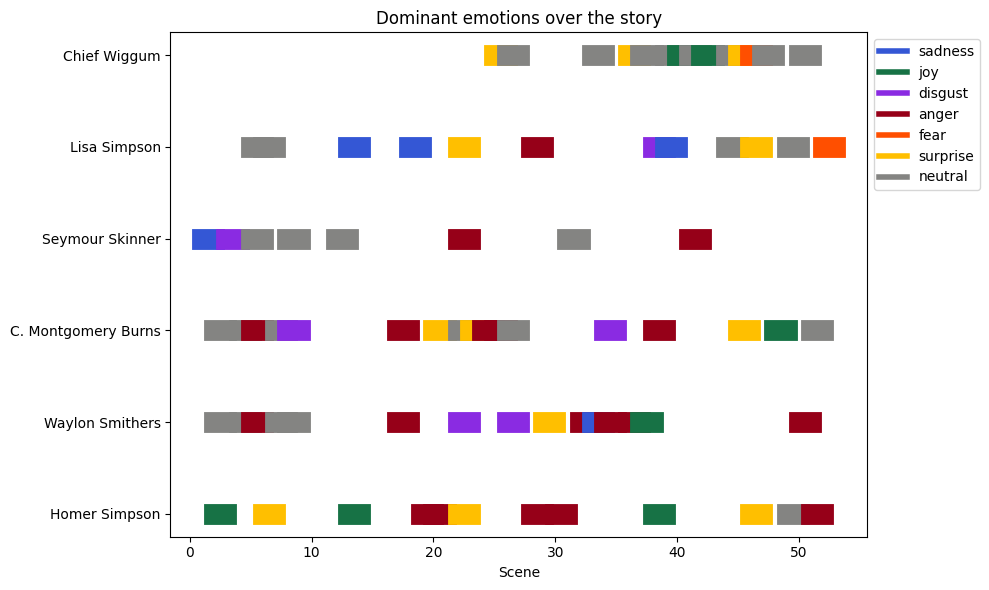

In [117]:
scenes = np.arange(1, max(simpsons_df['scene_number']) + 1)
emotion_evolution_plot(df_scenes, focus_players, color_palette, scenes)

In [60]:
character_mapping = {'Skinner':'Seymour Skinner', 'Willie':'Groundskeeper Willie', 'Bart':'Bart Simpson',
       'Burns':'C. Montgomery Burns', 'Smithers':'Waylon Smithers', 'Homer':'Homer Simpson','Maggie':'Maggie Simpson',
       'Lisa':'Lisa Simpson', 'Marge':'Marge Simpson', 'Grampa':'Grampa Simpson', 'Wiggum':'Chief Wiggum'
}
simpsons_df["refers"] = simpsons_df["refers"].map(character_mapping)

In [61]:
part_1_df = simpsons_df[simpsons_df['episode_id'] == 128]
part_2_df = simpsons_df[simpsons_df['episode_id'] == 129]

adj_list_1 = [(item[0], item[1],{"emotion": item[2]}) for item in part_1_df[['raw_character_text', 'refers', 'emotions']].values.tolist() if not pd.isna(item[1])]
adj_list_2 = [(item[0], item[1],{"emotion": item[2]}) for item in part_2_df[['raw_character_text', 'refers', 'emotions']].values.tolist() if not pd.isna(item[1])]

G_pt1 = nx.MultiDiGraph()
G_pt1.add_edges_from(adj_list_1)

G_pt2 = nx.MultiDiGraph()
G_pt2.add_edges_from(adj_list_2)

In [120]:
def plot_emotion_graph(G, palette):
    aggregated_edges = Counter([(u, v, data['emotion']) for u, v, data in G.edges(data=True)])
    G_aggregated = nx.DiGraph()
    for (u, v, emotion), count in aggregated_edges.items():
        G_aggregated.add_edge(u, v, weight=count, emotion=emotion)
    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(G_aggregated, k= 0.9)
    edge_colors = [palette[data['emotion']] for _, _, data in G_aggregated.edges(data=True)]
    edge_widths = [data['weight'] for _, _, data in G_aggregated.edges(data=True)]
    nx.draw(G_aggregated, pos, with_labels=True, node_size=1000, node_color='yellow', 
            edge_color = edge_colors, width = edge_widths, edge_cmap=plt.cm.jet)
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=emotion) for emotion, color in color_palette.items()]
    plt.legend(handles=legend_elements, loc="best")
    plt.title("Emotion Graph")
    plt.show()

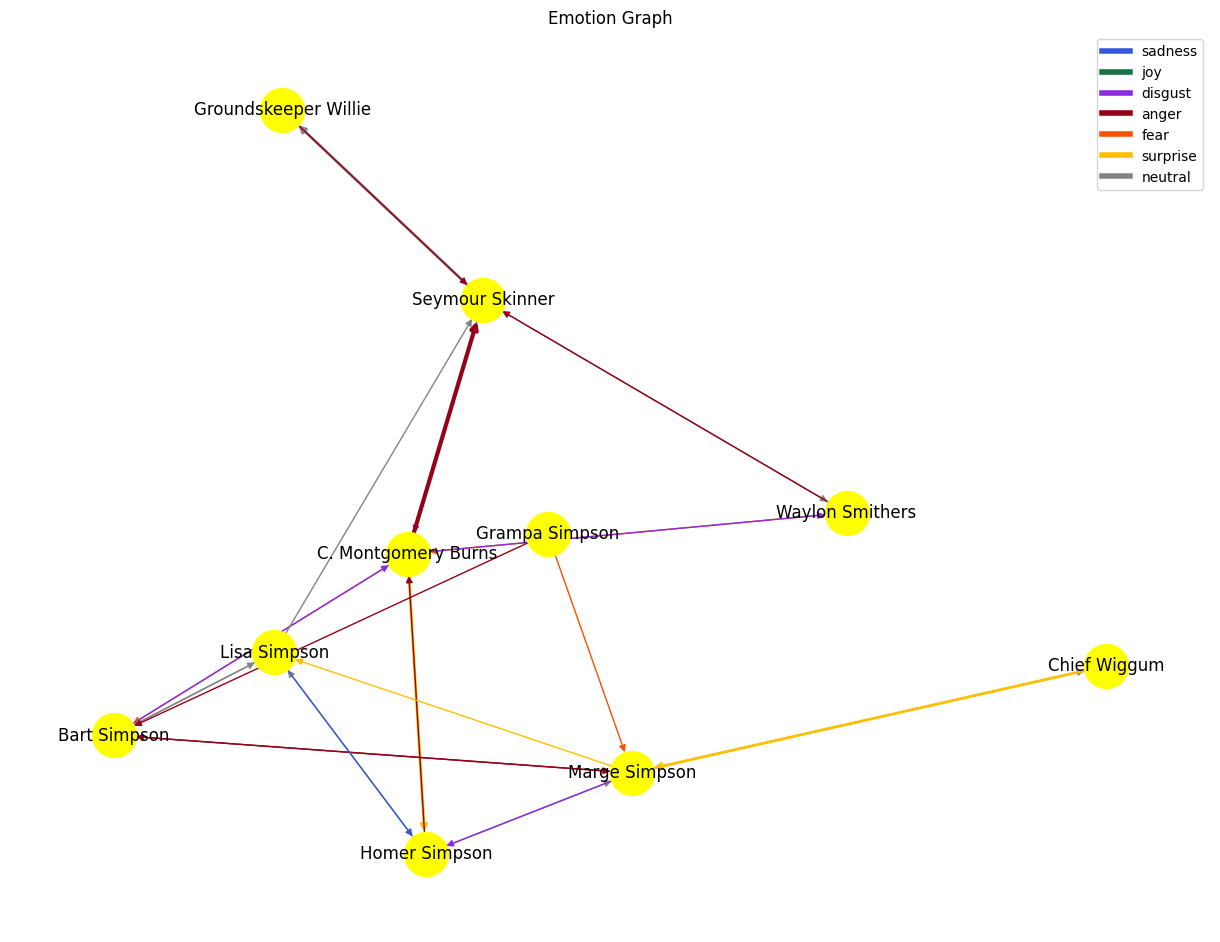

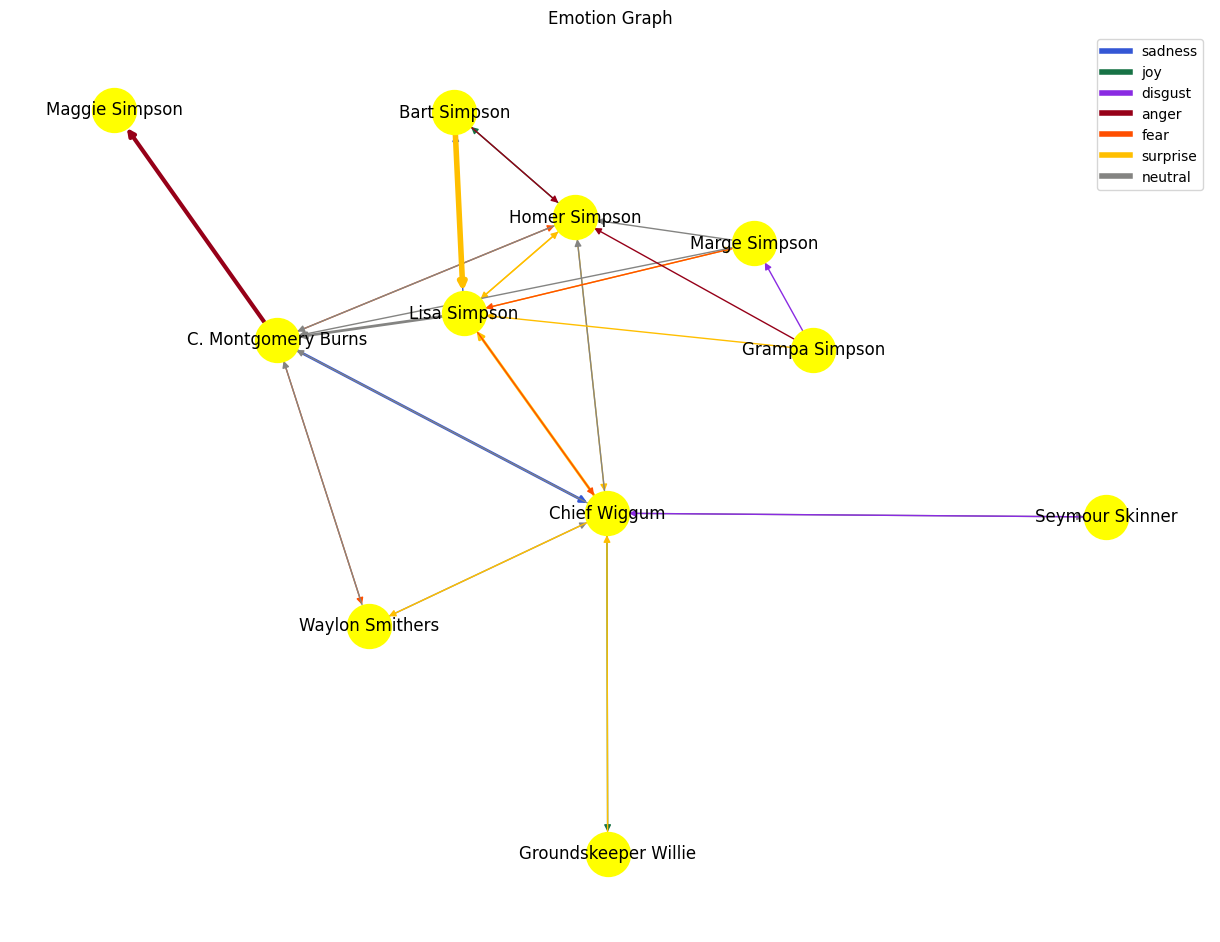

In [121]:
plot_emotion_graph(G_pt1, color_palette)
plot_emotion_graph(G_pt2, color_palette)